# 特征选择

##  单独选择
### 1. 方差大小  
    VarianceThreshold

In [57]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 1
np.random.seed(seed)
def plot_PCA(X, y, axis=None):
    if axis is None:
        axies= plt.gca()
    scores = PCA().fit_transform(X)
    axis.scatter(scores[:,0], scores[:,1], c=y)

<Container object of 20 artists>

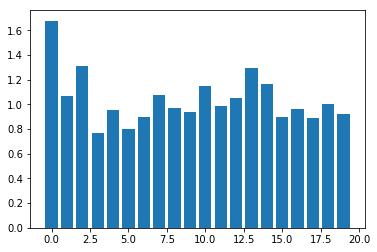

In [3]:
X, y = make_classification(n_samples=100, n_features=20, n_informative=2, n_redundant=2)
y.astype(np.int64)
vars_ = np.var(X, axis=0)
plt.bar(range(len(vars_)), vars_)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

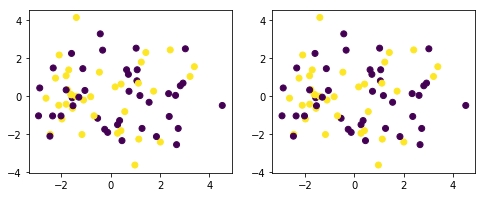

In [52]:
sel = VarianceThreshold(threshold=.7)
X_ = sel.fit_transform(X_train)
fig, axes = plt.subplots(1,2, figsize=(8,3))
plot_PCA(X_train, y_train, axes[0])
plot_PCA(X_, y_train, axes[1])

可以看出去掉方差很小的变量后，主成分得分图差异很小，说明去掉的变量不包含太多信息可以去掉

### 2. 单变量统计测试得分  
    SelectKbest, SelectPercentile, ...

In [53]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict,cross_val_score

In [54]:
steps = [SelectKBest(), LogisticRegression()]
pipe = make_pipeline(*steps)
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001AA5F0D8BF8>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])>

In [55]:
params = {'selectkbest__k': range(1,10)}
grid = GridSearchCV(pipe, params)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001AA5F0D8BF8>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'selectkbest__k': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [56]:
grid.best_params_, grid.best_score_

({'selectkbest__k': 1}, 0.96)

有效特征为2个，但是只用1个特征就达到了96%准确率

In [58]:
ypred = grid.predict(X_test)
print(classification_report(y_test, ypred))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96        11
          1       1.00      0.93      0.96        14

avg / total       0.96      0.96      0.96        25



## 2. 基于模型的变量选择

### 2.1 recursive feature selection

In [59]:
from sklearn.feature_selection import RFECV
lr = LogisticRegression()
selector = RFECV(lr)
selector.fit(X_train, y_train)

RFECV(cv=None,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [63]:
print(f'选择变量个数为： {selector.support_.sum()}')
selector.ranking_

选择变量个数为： 16


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 5, 1, 4, 3, 1])

In [64]:
grid = GridSearchCV(lr, param_grid={'C': np.power(2., range(-10,10))})\
        .fit(selector.transform(X_train), y_train)

In [62]:
print(classification_report(y_test, grid.predict(X_test)))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96        11
          1       1.00      0.93      0.96        14

avg / total       0.96      0.96      0.96        25



RFE选出了3个变量

### 2.2 L1 based
利用线性回归系数的L1正则，选择特征

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [71]:
lsvc = LinearSVC(penalty='l1', dual=False).fit(X_train, y_train)
selector = SelectFromModel(lsvc, prefit=True)
X_ = selector.transform(X_train)
grid = GridSearchCV(LinearSVC(), param_grid={'C': np.power(2., range(-10,10))})\
        .fit(X_, y_train)
print(classification_report(y_test, grid.predict(selector.transform(X_test))))
print(f'变量数为: {X_.shape[1]}')

             precision    recall  f1-score   support

          0       0.92      1.00      0.96        11
          1       1.00      0.93      0.96        14

avg / total       0.96      0.96      0.96        25

变量数为: 13


### 2.3 tree based

In [41]:
from sklearn.ensemble import ExtraTreesClassifier

In [75]:
clf = ExtraTreesClassifier(n_estimators=20)
clf.fit(X_train, y_train)
selector = SelectFromModel(clf, prefit=True)
X_ = selector.transform(X_train)
print(f'tree based 变量选择个数为：{X_.shape[1]}')
lr.fit(X_, y_train)
print(classification_report(y_test, lr.predict(selector.transform(X_test))))

tree based 变量选择个数为：3
             precision    recall  f1-score   support

          0       0.92      1.00      0.96        11
          1       1.00      0.93      0.96        14

avg / total       0.96      0.96      0.96        25



1. cross_val_score中模型的超参数是先fitted， 然后再fittted模型参数
2. cross_val_score是取平均
3. corss_val_predict没有取平均  
[Model blending](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

## 参考资料
[sklearn doc: Feature selection](http://scikit-learn.org/stable/modules/feature_selection.html)